# Problem: Implement an LSTM Model 

### Problem Statement
You are tasked with implementing a simple **LSTM (Long Short-Term Memory)** model in PyTorch. The model should process sequential data using an LSTM layer followed by a fully connected (FC) layer. Your goal is to complete the model by defining the LSTM layer and implementing the forward pass.

### Requirements
1. **Define the LSTM Model**:
   - Add an **LSTM layer** to the model. This layer should accept input sequences and output hidden states.
   - Add a **fully connected (FC) layer** that maps the output of the LSTM to the final predictions.
   - Implement the `forward` method to:
     - Pass the input sequence through the LSTM.
     - Feed the output of the LSTM into the fully connected layer for the final output.

### Constraints
- The LSTM layer should be implemented with a single hidden layer.
- Use a suitable number of input features, hidden units, and output size for the task.
- Make sure the `forward` method returns the output of the fully connected layer after processing the LSTM output.


<details>
  <summary>💡 Hint</summary>
  Add the LSTM layer and FC layer in LSTMModel.__init__.
  <br>
  Implement the forward pass to process sequences using the LSTM and FC layers.
</details>

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Generate synthetic sequential data
torch.manual_seed(42)
sequence_length = 10
num_samples = 100

# Create a sine wave dataset
X = torch.linspace(0, 4 * 3.14159, steps=num_samples).unsqueeze(1)
y = torch.sin(X)

# Prepare data for LSTM
def create_in_out_sequences(data, seq_length):
    in_seq = []
    out_seq = []
    for i in range(len(data) - seq_length):
        in_seq.append(data[i:i + seq_length])
        out_seq.append(data[i + seq_length])
    return torch.stack(in_seq), torch.stack(out_seq)

X_seq, y_seq = create_in_out_sequences(y, sequence_length)

In [3]:
class CustomLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super().__init__()
        weights_biases_init = lambda : (nn.Parameter(torch.randn(input_dim, hidden_units)),
                                        nn.Parameter(torch.randn(hidden_units, hidden_units)),
                                        nn.Parameter(torch.zeros(hidden_units)))
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.Wxi, self.Whi, self.bi = weights_biases_init()
        self.Wxf, self.Whf, self.bf = weights_biases_init()
        self.Wxo, self.Who, self.bo = weights_biases_init()
        self.Wxc, self.Whc, self.bc = weights_biases_init()
        self.fc = nn.Linear(hidden_units, 1)
        # print(self.Wxi.shape, self.Whi.shape, self.bi.shape)
        
    def forward(self, inputs, H_C=None):
        # print(inputs.shape, self.Wxi.shape)
        batch_size, seq_len, _ = inputs.shape
        if not H_C:
            H = torch.randn(batch_size, self.hidden_units)
            C = torch.randn(batch_size, self.hidden_units)
        else:
            H, C = H_C
            
        all_hidden_states = []
        for t in range(seq_len):  
            X_t = inputs[:, t, :]
            # print(X.shape, self.Wxi.shape, self.Whi.shape, self.bi.shape)  
            I_t = torch.sigmoid(torch.matmul(X_t, self.Wxi) + torch.matmul(H, self.Whi) + self.bi)
            F_t = torch.sigmoid(torch.matmul(X_t, self.Wxf) + torch.matmul(H, self.Whf) + self.bf)
            O_t = torch.sigmoid(torch.matmul(X_t, self.Wxo) + torch.matmul(H, self.Who) + self.bo)
            C_tilde = torch.tanh(torch.matmul(X_t, self.Wxc) + torch.matmul(H, self.Whc) + self.bc)
            C = F_t * C + I_t * C_tilde
            H = O_t * torch.tanh(C)
            # print(H.shape)
            all_hidden_states.append(H.unsqueeze(1))
            
        outputs = torch.cat(all_hidden_states, dim=1)
        pred = self.fc(outputs)
        # print(pred.shape)
        return pred, (H, C)
        

In [4]:
# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the LSTM
        return out

In [5]:
# Initialize the model, loss function, and optimizer
model_custom = CustomLSTMModel(1, 50)
model_inbuilt = LSTMModel()
criterion = nn.MSELoss()
optimizer_custom = optim.Adam(model_custom.parameters(), lr=0.01)
optimizer_inbuilt = optim.Adam(model_inbuilt.parameters(), lr=0.01)

In [6]:
# Training loop for the custom model
epochs = 500
for epoch in range(epochs):
    # Forward pass
    state = None
    pred, state = model_custom(X_seq, state)
    loss = criterion(pred[:, -1, :], y_seq) # Use the last output of the LSTM
    # Backward pass and optimization
    optimizer_custom.zero_grad()
    loss.backward()
    optimizer_custom.step()

    # Log progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [50/500], Loss: 0.0996
Epoch [100/500], Loss: 0.0898
Epoch [150/500], Loss: 0.0785
Epoch [200/500], Loss: 0.0667
Epoch [250/500], Loss: 0.0559
Epoch [300/500], Loss: 0.0356
Epoch [350/500], Loss: 0.0268
Epoch [400/500], Loss: 0.0229
Epoch [450/500], Loss: 0.0192
Epoch [500/500], Loss: 0.0142


In [9]:
# Training loop for the inbuilt model
epochs = 500
for epoch in range(epochs):
    # Forward pass
    pred = model_inbuilt(X_seq)
    loss = criterion(pred, y_seq)
    # Backward pass and optimization
    optimizer_inbuilt.zero_grad()
    loss.backward()
    optimizer_inbuilt.step()

    # Log progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [50/500], Loss: 0.0010
Epoch [100/500], Loss: 0.0001
Epoch [150/500], Loss: 0.0000
Epoch [200/500], Loss: 0.0000
Epoch [250/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [350/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [450/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000


In [19]:
# Testing on new data
test_steps = 100  # Ensure this is greater than sequence_length
X_test = torch.linspace(0, 5 * 3.14159, steps=test_steps).unsqueeze(1)
y_test = torch.sin(X_test)

# Create test input sequences
X_test_seq, _ = create_in_out_sequences(y_test, sequence_length)

with torch.no_grad():
    pred_custom, _ = model_custom(X_test_seq)
    pred_inbuilt = model_inbuilt(X_test_seq)
pred_custom = torch.flatten(pred_custom[:, -1, :])
pred_inbuilt = pred_inbuilt.squeeze()
print(f"Predictions with Custom Model for new sequence: {pred_custom.tolist()}")
print(f"Predictions with In-Built Model: {pred_inbuilt.tolist()}")


Predictions with Custom Model for new sequence: [0.8722591996192932, 0.8946256041526794, 0.8925198912620544, 0.9096068739891052, 0.7193865776062012, 0.8029537796974182, 0.7611545920372009, 0.6357396841049194, 0.39185675978660583, 0.15291088819503784, 0.0017629489302635193, -0.1545099914073944, -0.2593921720981598, -0.5998544096946716, -0.6508030891418457, -0.7302036881446838, -0.7933940291404724, -0.7178914546966553, -0.8878818154335022, -0.9227510094642639, -0.6303256154060364, -0.9827148914337158, -1.023526906967163, -0.7632614970207214, -0.8843759894371033, -0.6467899680137634, -0.7290364503860474, -0.3021402657032013, -0.23509612679481506, -0.42650213837623596, 0.030517645180225372, 0.08275053650140762, 0.1288076937198639, 0.743124783039093, 0.7048536539077759, 0.7476622462272644, 0.8374730944633484, 0.6570764183998108, 0.9516618847846985, 0.9500941634178162, 0.9618882536888123, 0.8920931220054626, 0.8603857159614563, 0.7005499005317688, 0.90570467710495, 0.7393853068351746, 0.5955

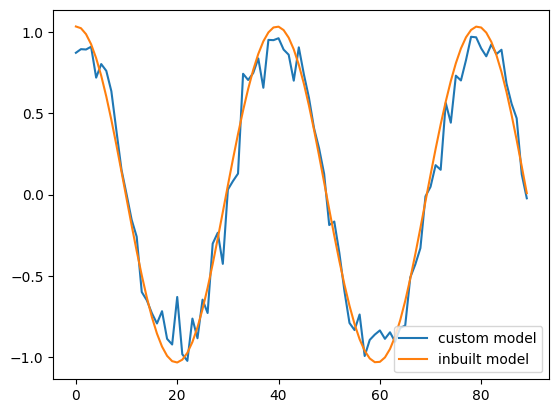

In [22]:
#Plot the predictions
plt.figure()
# plt.plot(y_test, label="Ground Truth")
plt.plot(pred_custom, label="custom model")
plt.plot(pred_inbuilt, label="inbuilt model")
plt.legend()
plt.show()